### Домашнее задание

In [ ]:
# 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия 
# (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
# 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
# 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 
# (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). 
# (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
# 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
# 5. (опционально) Еще раз провести оценку экономической эффективности

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import random
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
random.seed(666)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [ ]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [ ]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

#### **Случайный лес**

In [ ]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [ ]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [ ]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


#### **Вопрос 1: объясните своими словами смысл метрик Precison, Recall**
**1. Какова их взаимосвязь и как с ними связан порог вероятности?**

**2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision**

**3. Аналогичный вопрос про precision**

**Ответ:**

**Precision** - это доля объектов, которые модель назвала положительными и при этом они действительно являются положительными.

**Recall** - это доля объектов положительного класса из всех объектов положительного класса, которые определила модель.

Порог вероятности выражает компромисс между метриками Precision (точность) и Recall (полнота), если растет точность, то падает полнота, и наоборот, если растет полнота, то снижается точность.

Отрисуем матрицу ошибок

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


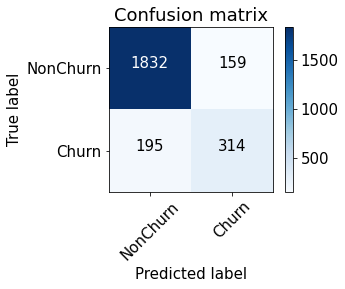

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

**Ответ:**

Всего будет потрачено на удержание $= \,(159+314)*1=473$ $.

Ожидаемая прибыль с TP $= \,314*2 = 628$ $.

Экономическая эффективность $= \,628-473=155$ $

Таким образом, модель является потенциально экономически целесообразной, так как на удержание будет потрачено меньше средств, чем получено после удержания этих пользователей, даже с учетом ошибно помеченных пользователей, как отток.

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [ ]:
params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [ ]:
# grid = GridSearchCV(pipeline,
#                     param_grid=params,
#                     cv=6,
#                     refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

# {'classifier__max_depth': None,
#  'classifier__max_features': 0.5,
#  'classifier__min_samples_leaf': 3}

Обучаем модель уже сновыми параметрами

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [ ]:
table_comp = pd.DataFrame({'Model': [],
                           'Threshold': [],
                           'F-Score': [],
                           'Precision': [],
                           'Recall': [],
                           'ROC AUC': [],
                           'TP': [],
                           'FP': [],
                           'TN': [],
                           'FN': []})

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


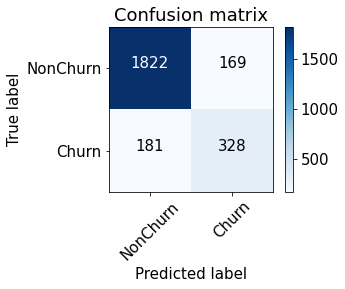

In [ ]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

table_comp.loc[0] = ['RandomForestClassifier', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds), cnf_matrix[1][1], cnf_matrix[0][1], cnf_matrix[0][0], cnf_matrix[1][0]]

Метрики немного стали выше

#### **Логистическая регрессия**

In [ ]:
final_transformers_lr = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers_lr.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
                ('standard', StandardScaler())
            ])
    final_transformers_lr.append((cont_col, cont_transformer))

feats_st = FeatureUnion(final_transformers_lr)
feature_processing_st = Pipeline([('feats', feats_st)])

pipeline_logreg = Pipeline([
    ('features_st', feats_st),
    ('classifier_lr', LogisticRegression(random_state=42)),
])

pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('features_st',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
        

In [ ]:
preds_lg = pipeline_logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


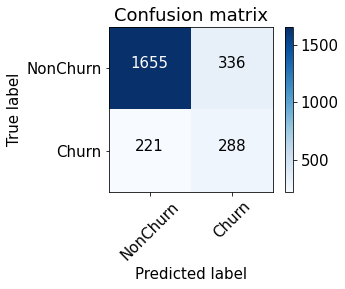

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lg)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_lg>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

table_comp.loc[1] = ['LogisticRegression', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds_lg), cnf_matrix[1][1], cnf_matrix[0][1], cnf_matrix[0][0], cnf_matrix[1][0]]

#### **Градиентный спуск**


In [ ]:
pipeline_gb = Pipeline([
    ('features_st', feats_st),
    ('classifier_gb', GradientBoostingClassifier(max_depth=5, n_estimators=50, 
                                          learning_rate=0.1, random_state=42)),
])
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features_st',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
        

In [ ]:
params={'classifier_gb__max_depth':[2, 3, 5, 7],
        'classifier_gb__n_estimators':[50, 100, 150],
        'classifier_gb__learning_rate':[0.01, 0.1, 0.5]
        }

In [ ]:
# grid = GridSearchCV(pipeline_gb,
#                     param_grid=params,
#                     cv=6,
#                     refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

# {'classifier_gb__learning_rate': 0.1,
#  'classifier_gb__max_depth': 3,
#  'classifier_gb__n_estimators': 150}

In [ ]:
pipeline_gb = Pipeline([
    ('features_st', feats_st),
    ('classifier_gb', GradientBoostingClassifier(max_depth=3, n_estimators=150, 
                                          learning_rate=0.1, random_state=42)),
])
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features_st',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
        

Best Threshold=0.375149, F-Score=0.649, Precision=0.671, Recall=0.629
Confusion matrix, without normalization
[[1834  157]
 [ 190  319]]


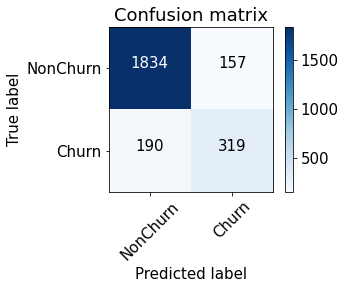

In [ ]:
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gb>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

table_comp.loc[2] = ['GradientBoostingClassifier', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds_gb), cnf_matrix[1][1], cnf_matrix[0][1], cnf_matrix[0][0], cnf_matrix[1][0]]

In [ ]:
table_comp[['TP', 'FP', 'TN', 'FN']] = table_comp[['TP', 'FP', 'TN', 'FN']].astype(int)
table_comp

,Model,Threshold,F-Score,Precision,Recall,ROC AUC,TP,FP,TN,FN
0,RandomForestClassifier,0.389431,0.653426,0.660643,0.646365,0.869511,328,169,1822,181
1,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077,288,336,1655,221
2,GradientBoostingClassifier,0.375149,0.649087,0.670860,0.628684,0.875384,319,157,1834,190


**Ответ:** 

Наилучшую точность по метрикам Precision и Roc Auc показала модель Градиентного бустинга. В данном случае лучше всего подходит метрика Precision, так как нам важна доля объектов, которые модель назвала положительными и при этом они действительно являются положительными, потому что именно от них мы будем получать прибыль (тех, кого мы определили как отток).

Всего будет потрачено на удержание $= \,(157+319)*1=476$ $.

Ожидаемая прибыль с TP $= \,319*2 = 638$ $.

Экономическая эффективность $= \,638-476=162$ $

Исходя из расчетов выше, модель является потенциально экономически целесообразной.